# Analiza danych #1 Kto przeżyje katastrofę?

### Zatonięcie Titanica jest niewątpliwie najbardziej znaną katastrofą morską w historii. Każdy z nas coś o tym wydarzeniu wie - to, skąd i dokąd płynął Titanic, w którym roku odbył się rejs i tym podobne. Ale czy nie byłoby ciekawie dowiedzieć się czegoś na temat tego... kim byli jego pasażerowie? Z jakich klas społecznych pochodzili, w jakim byli wieku i w końcu jaki wpływ miały te cechy na to kto przeżył katastrofę? Okazuje się, że mamy taką możliwość. 

Jeśli ktoś stawiał choćby pierwsze kroki w tematyce machine learningu to na pewno wie o tym, że te dane są dostępne publicznie. Ze wszystkich 1311 pasażerów mamy informacje aż o 1309 z nich. Posiadamy dostęp do takich informacji jak na przykład: imię i nazwisko pasażera, jego wiek, płeć, klasa którą podróżował a nawet ilu członków jego rodziny znajdowało się na pokładzie podczas rejsu. Po pobraniu i wyczyszczeniu niekompletnych rekordów bazy danych pozostają informacje dotyczące 1043 pasażerów, czyli 79% całości (załoga statku nie została uwzględniona). W tym wpisie zwizualizuję i omówię dane dotyczące uczestników rejsu oraz pokażę w jaki sposób za pomocą regresji logistycznej stworzyć model, który na podstawie kilku informacji o pasażerze pozwoli przewiedzieć co jest w jego przypadku bardziej prawdopodobne - śmierć czy ratunek.


## Początek podróży - kto gdzie wsiadł i ile miał pieniędzy?

Titanic wyruszył 10 kwietnia 1912 roku z Southampton na południu Anglii. Zanim wypłynął na wody Atlantyku zatrzymał się jeszcze we francuskim Cherbourg oraz irlandzkim Queenstown (Irlandia należała w tym czasie do imperium brytyjskiego). To pozwala z pewnym przybliżeniem podzielić pasażerów Titanica na trzy grupy - Anglików, Europejczyków z kontynentu i Irlandczyków. W której z tych grup najwięcej osób mogło pozwolić sobie na podróż pierwszą klasą, a w której dominowali posiadacze najtańszych biletów klasy trzeciej? Zobaczmy... 

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import pandas as pd

# ------------- I. Wczytanie datasetu i reorganizacja danych ---------------------
visualData = pd.read_csv('dane/titanic.csv',sep=';')        # połączone datasety train i test

# kolumny do wykasowania to: PassengerId, Name, Ticket, Cabin
visualData.drop(['PassengerId', 'Name','Ticket','Cabin'],inplace = True, axis=1)  # skasowanie tych kolumn

# najniższa cena biletu to 8 funtów
visualData.loc[visualData['Fare'] <= 8, ['Fare']] = np.mean(visualData['Fare'])  

# najwyższa cena biletu to 250 funtów
visualData.loc[visualData['Fare'] > 250, ['Fare']] = \
np.mean(visualData[visualData['Pclass']==1]['Fare'])  

visualData.dropna(inplace = True)         # usunięcie wierszy z nanem

# dodanie kolumny 'Family' która jest sumą 'SibSp' i 'Parch' i usunięcie tych drugich
visualData['Family'] = visualData['SibSp'] + visualData['Parch']
visualData.drop(['SibSp', 'Parch'], inplace = True, axis = 1)
# zamiana pierwszych liter miast na całe miasta
visualData['Embarked'].replace('Q','Queensland',inplace = True)
visualData['Embarked'].replace('C','Cherbourg',inplace = True)
visualData['Embarked'].replace('S','Southampton',inplace = True)



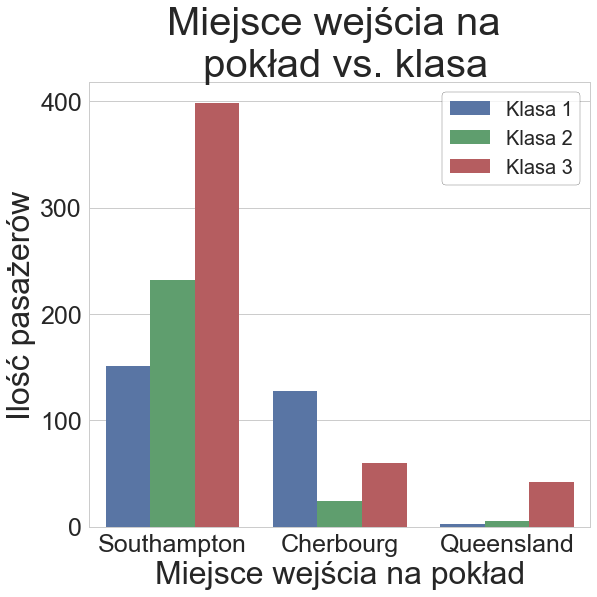

In [21]:
# # ----------------- II. wizualizacja -------------------------------------
# 1. Countlot z podziałem na miejsce gdzie wsiedli i hue z podziałem na klasy

sns.set(font_scale=2.5,palette = 'deep',rc={'figure.figsize':(9,9)})
sns.set_style('whitegrid')

fig = sns.countplot(x = 'Embarked', hue = 'Pclass', data = visualData)
fig.set_title('Miejsce wejścia na \n pokład vs. klasa',fontsize = 40)
fig.set_xlabel('Miejsce wejścia na pokład', fontsize = 32)
fig.set_ylabel('Ilość pasażerów', fontsize = 32)

fig.legend(['Klasa 1', 'Klasa 2', 'Klasa 3'], fontsize = 20, frameon = True, edgecolor = 'black')

plt.tight_layout()


Rozkład ilości pasażerów w poszczególnych klasach spośród tych, którzy wsiedli w pierwszym - angielskim - porcie jest wzorcowy i nie zaskakuje. Tak jak można się spodziewać, pasażerów którzy mogli sobie pozwolić na podróż pierwszą klasą jest najmniej. Nieco więcej wybrało drugą klasę, a ta najtańsza cieszyła się największą popularnością. Przy okazji widać też, że w Southampton wsiadło zdecydowanie najwięcej pasażerów. 

 Ciekawie natomiast wyglądają dane dotyczące pasażerów, którzy wsiedli w Cherbourg. Można co do nich podejrzewać, że w dużej części pochodzili z Europy kontynentalnej, jednak wgląd w dane pokazuje, że znaleźli się tam również posiadacze angielskich nazwisk. Tutaj większość pasażerów popłynęło pierwszą klasą a drugą zdecydowanie najmniejsza część. Zupełnie inaczej sprawa miała się w irlandzkim Queenstown - tam prawie wszyscy popłynęli klasą trzecią co niesie konkretną informację na temat irlandzkiej sytuacji społeczno-ekonomicznej w tamtych czasach. Możemy zobaczyć również jaki był rozkład cen biletów w poszczególnych klasach. Najtańszy bilet kosztował 8 funtów, natomiast najdroższy - 250.


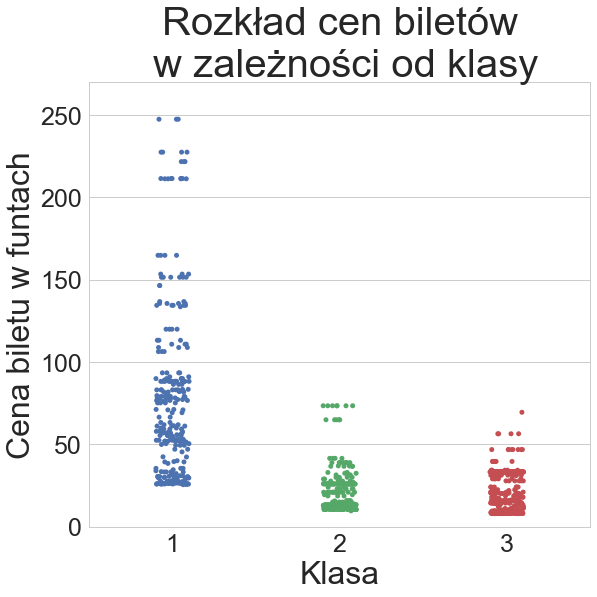

In [33]:
# 2. Stripplot obrazujący korelację między ceną a klasą

sns.set(font_scale=2.5,palette = 'deep',rc={'figure.figsize':(9,9)})
sns.set_style('whitegrid')

fig = sns.stripplot(x = 'Pclass', y = 'Fare', data = visualData, jitter = 1)
fig.set_title('Rozkład cen biletów\n w zależności od klasy',fontsize = 40)
fig.set_xlabel('Klasa', fontsize = 32)
fig.set_ylabel('Cena biletu w funtach', fontsize = 32)
fig.set_ylim([0,270])

plt.tight_layout()

## W jakim wieku byli pasażerowie?

Skoro mamy już pewne pojęcie na temat zamożności pasażerów Titanica, ktoś może się teraz zastanowić w jakim byli wieku. Przekonajmy się. 


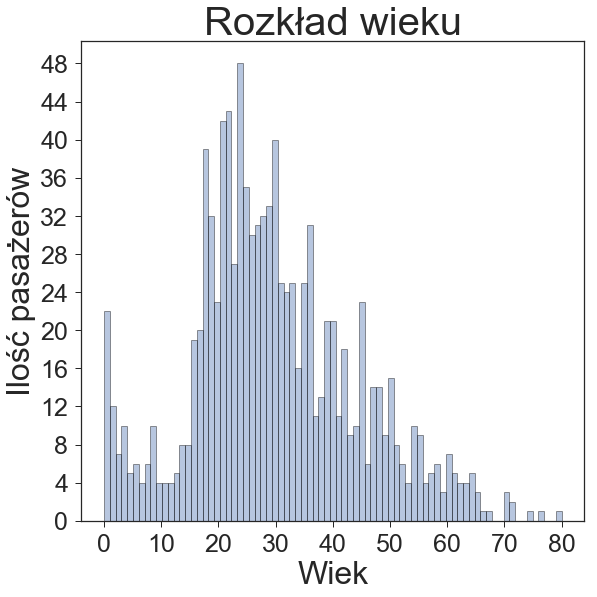

In [23]:
# 3. Histogram ilości osób dla wszystkich przedziałów wiekowych

sns.set(font_scale=2.5,palette = 'deep',rc={'figure.figsize':(9,9)})
sns.set_style('ticks')

fig = sns.distplot(visualData['Age'], kde = False, bins = np.linspace(0,80,80),hist_kws=dict(edgecolor="k", linewidth=1))
plt.xticks(np.arange(0, 81, 10))
plt.yticks(np.arange(0,49, 4))
fig.set_title('Rozkład wieku',fontsize = 40)
fig.set_xlabel('Wiek', fontsize = 32)
fig.set_ylabel('Ilość pasażerów', fontsize = 32)

plt.tight_layout()

Rozkład wieku mniej lub bardziej przypomina normalny, ale to co od razu rzuca się w oczy a odbiega od tego rozkładu to duża ilość dzieci, zwłaszcza niemowląt. Każdy słupek na histogramie odpowiada wiekowi z dokładnością do jednemu roku. Wartość najczęstsza rozkładu przypada na wczesne lata dwudzieste. To jak wiele było na pokładzie małych dzieci może sugerować, że do Stanów Zjednoczonych płynęły młode rodziny z dziećmi, być może szukające lepszego życia za oceanem. Najmłodszy pasażer, a właściwie pasażerka - Millvina Dean - miała w chwili rejsu zaledwie dwa miesiące. Była ona zresztą najdłużej żyjącą po katastrofie osobą. Zmarła w 2009 roku w wieku 97 lat. 

## Kto przeżył?

Zależność wskaźnika przeżywalności od wieku najlepiej zobrazować poprzez nałożenie na poprzedni histogram podobnego, ale jedynie z osobami, które przeżyły. 


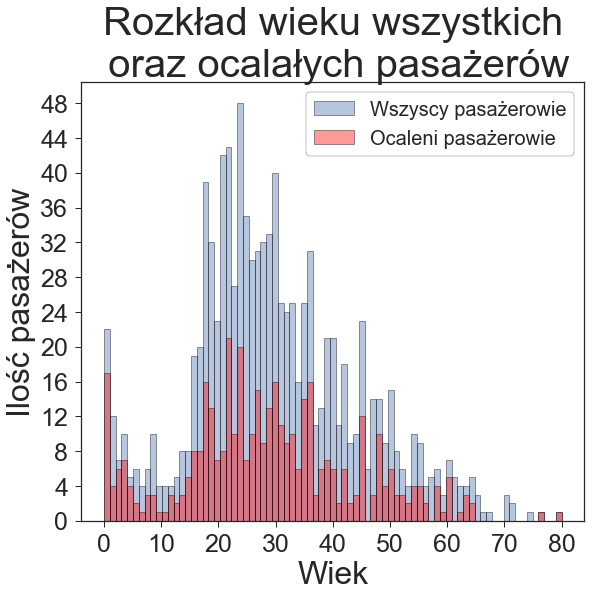

In [24]:
# 4. Histogram ilości osób dla wszystkich przedziałów wiekowych i nałożony na niego histogram osób, które przeżyły

sns.set(font_scale=2.5,palette = 'deep',rc={'figure.figsize':(9,9)})
sns.set_style('ticks')

fig = sns.distplot(visualData['Age'], kde = False, bins = np.linspace(0,80,80),hist_kws=dict(edgecolor="k", linewidth=1))
fig = sns.distplot(visualData[visualData['Survived']==1]['Age'], color = 'red', kde = False, bins = np.linspace(0,80,80),hist_kws=dict(edgecolor="k", linewidth=1))
plt.xticks(np.arange(0, 81, 10))
plt.yticks(np.arange(0, 49, 4))
fig.set_title('Rozkład wieku wszystkich\n oraz ocalałych pasażerów',fontsize = 40)
fig.set_xlabel('Wiek', fontsize = 32)
fig.set_ylabel('Ilość pasażerów', fontsize = 32)
plt.legend(['Wszyscy pasażerowie','Ocaleni pasażerowie'], fontsize = 20, frameon = True, edgecolor = 'black')

plt.tight_layout()

Prawdopodobieństwo przeżycia nie zależało od wieku w bardzo znaczący sposób, ale histogram nieco się spłaszczył, co pokazuje że stosunkowo najwięcej osób które zginęły było w okolicach 20-30 lat. Natomiast najmłodsi i najstarsi pasażerowie mieli większą szansę na przeżycie.

Jednak jest coś co wpłynęło na prawdopodobieństwo przetrwania o wiele bardziej niż wiek. Była to oczywiście płeć. Potwierdza się zasada ratowania w pierwszej kolejności kobiet, starców i dzieci. Analogiczne histogramy jak ten powyżej dla poszczególnych płci przedstawiają się następująco:


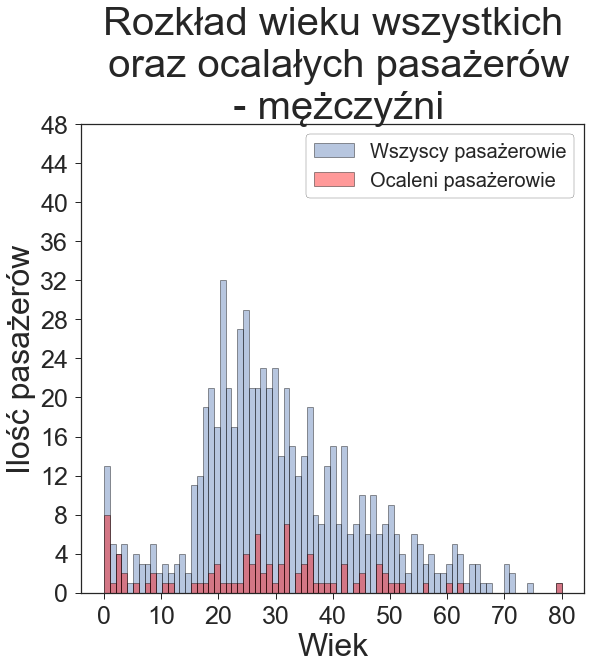

In [29]:
# 5. Histogram ilości mężczyzn dla wszystkich przedziałów wiekowych i nałożony na niego histogram mężczyzn, którzy przeżyli

sns.set(font_scale=2.5,palette = 'deep',rc={'figure.figsize':(9,10)})
sns.set_style('ticks')

fig = sns.distplot(visualData[visualData['Sex']=='male']['Age'], kde = False, bins = np.linspace(0,80,80),hist_kws=dict(edgecolor="k", linewidth=1))
fig = sns.distplot(visualData[(visualData['Sex']=='male') & (visualData['Survived']==1)]['Age'], color = 'red', kde = False, bins = np.linspace(0,80,80),hist_kws=dict(edgecolor="k", linewidth=1))
plt.xticks(np.arange(0, 81, 10))
plt.yticks(np.arange(0, 49, 4))
fig.set_title('Rozkład wieku wszystkich\n oraz ocalałych pasażerów\n - mężczyźni',fontsize = 40)
fig.set_xlabel('Wiek', fontsize = 32)
fig.set_ylabel('Ilość pasażerów', fontsize = 32)
plt.legend(['Wszyscy pasażerowie','Ocaleni pasażerowie'], fontsize = 20, frameon = True, edgecolor = 'black')

plt.tight_layout()

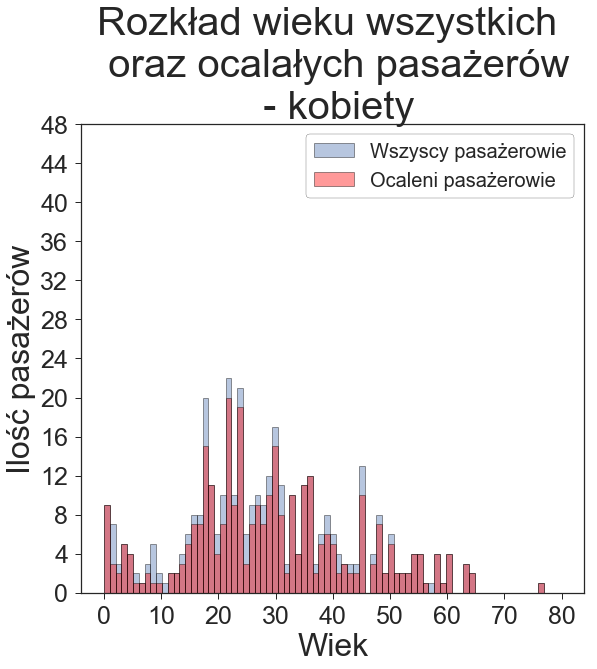

In [31]:
# 6. Histogram ilości kobiet dla wszystkich przedziałów wiekowych i nałożony na niego histogram kobiet, które przeżyły

sns.set(font_scale=2.5,palette = 'deep',rc={'figure.figsize':(9,10)})
sns.set_style('ticks')

fig = sns.distplot(visualData[visualData['Sex']=='female']['Age'], kde = False, bins = np.linspace(0,80,80),hist_kws=dict(edgecolor="k", linewidth=1))
fig = sns.distplot(visualData[(visualData['Sex']=='female') & (visualData['Survived']==1)]['Age'], color = 'red', kde = False, bins = np.linspace(0,80,80),hist_kws=dict(edgecolor="k", linewidth=1))
plt.xticks(np.arange(0, 81, 10))
plt.yticks(np.arange(0, 49, 4))
fig.set_title('Rozkład wieku wszystkich \n oraz ocalałych pasażerów\n - kobiety',fontsize = 40)
fig.set_xlabel('Wiek', fontsize = 32)
fig.set_ylabel('Ilość pasażerów', fontsize = 32)
plt.legend(['Wszyscy pasażerowie','Ocaleni pasażerowie'], fontsize = 20, frameon = True, edgecolor = 'black')

plt.tight_layout()

Ze wszystkich 415 ocalałych pasażerów (którzy podczas czyszczenia danych nie zostali usunięci z bazy) aż 322 to kobiety (stanowi to 76%). Jednak nie tylko płeć była istotnym kryterium, które korelowało z tym kto przeżył katastrofę. Nie będzie zaskoczeniem, że wśród ocalałych względnie więcej było pasażerów pierwszej klasy niż trzeciej. Zależność wskaźnika przeżywalności od zarówno płci jak i klasy została zobrazowana na poniższym wykresie. Chociaż kryterium płci wyraźnie przeważa to jednak klasa podróżującego na pewno nie była bez znaczenia. 

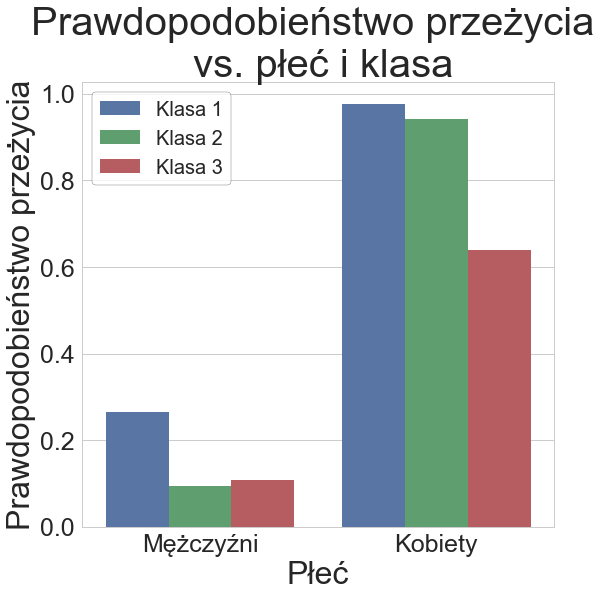

In [40]:
# 7. Procent tych, którzy przeżyli z podziałem na klasy i płeć

sns.set(font_scale=2.5,palette = 'deep',rc={'figure.figsize':(9,9)})
sns.set_style('whitegrid')

fig = sns.barplot(x='Sex', y='Survived', hue='Pclass', ci=None, data=visualData)
fig.set_title('Prawdopodobieństwo przeżycia \n vs. płeć i klasa',fontsize = 40)
fig.set_xlabel('Płeć', fontsize = 32)
fig.set_ylabel('Prawdopodobieństwo przeżycia', fontsize = 32)
fig.set_xticklabels(['Mężczyźni','Kobiety'])

fig.legend(['Klasa 1', 'Klasa 2', 'Klasa 3'], fontsize = 20, frameon = True, edgecolor = 'black', loc = 0)

plt.tight_layout()

## Jak przewidzieć szansę ocalenia?

Wizualizacja danych pasażerów pokazuje, że występują korelacje pomiędzy pewnymi ich cechami - takimi jak płeć, wiek czy klasa, którą podróżowali - a prawdopodobieństwem przeżycia. Czy w takim razie gdyby okazało sie, że na pokładzie były jeszcze inne osoby, których cechy możemy poznać jesteśmy w stanie przewidzieć co jest dla nich bardziej prawdopodobną perspektywą na przyszłość - śmierć czy ocalenie? Owszem. Tutaj przychodzi z pomocą machine learning. Za pomocą odpowiedniej metody, która 'dostrzeże' statystyczne zależności można stworzyć model pozwalający na przypisanie pasażera (reprezentowanego przez wektor parametrów - swoich cech) do jednej z dwóch kategorii. W tym przypadku te kategorie to 'przeżyje' i 'nie przeżyje'. Metoda, o której mowa to regresja logistyczna - jeden z podstawowych algorytmów klasyfikacyjnych uczenia maszynowego.

## Budowa modelu i tworzenie predykcji

Regresja logistyczna to metoda nadzorowana (ang. *supervised*), co oznacza że zanim model będzie mógł dokonywać predykcji trzeba go tego "nauczyć" z wykorzystaniem opisanych danych. Opisanych czyli takich, które zawierają informacje o zarówno zmiennych określających (albo też cechach, ang. features) jak i zmiennej określanej (docelowej, ang. target). Taki zbiór danych oczywiście posiadamy. W naszym przypadku zmienne określające to wszystkie informacje o pasażerze poza tą czy przeżył. Ona z kolei stanowi zmienną określaną. Następnie należy wydzielić z naszych danych podzbiór (stanowiący zwykle około 60-70% całości) który będziemy nazywać danymi uczącymi. Nauka sprowadza się tak naprawdę do znalezienia wektora (listy, zestawu) pewnych stałych współczynników liczbowych - ale o tym później. Pozostałe 30-40% część początkowego zbioru danych to tak zwane dane testowe albo walidacyjne. Test polega na przekazaniu macierzy cech (po jednym wektorze na każdego "testowanego" pasażera) do modelu predykcyjnego, który przyporządkowuje pasażerom swoją ocenę ich losu. Im wyraźniejsze korelacje występują między ficzerami i targetem tym te strzały będą bardziej trafne.  Następnie to co przewidział model porównywane zostaje z rzeczywistymi informacjami o tym czy dany pasażer przeżył czy też nie. 

## Trochę matematyki

Nie będę dokładnie omawiać niskopoziomowego podłoża tej metody, ale napiszę kilka zdań na temat tego jak reprezentowana jest szansa przeżycia (w ogólności - logicznej jedynki zwróconej przez nasz algorytm). Tak naprawdę obliczane jest coś w rodzaju prawdopodobieństwa, że konkretnemu przypadkowi testowemu należy przypisać wartość 1.  Jeżeli to prawdopodobieństwo (mające oczywiście przebieg ciągły) przekroczy 0.5 lub będzie tyle równe - wtedy algorytm zwraca jedynkę. W przeciwnym razie - zero. Jakim wzorem wyraża się to prawdopodobieństwo? 


$$ p = \dfrac{\text{e}^{a_0}\cdot \text{e}^{a_1\cdot x_1} \cdot \text{e}^{a_2\cdot x_2}\cdot ...}{1+\text{e}^{a_0}\cdot \text{e}^{a_1\cdot x_1} \cdot \text{e}^{a_2\cdot x_2}\cdot ...}  $$

$\vec a = (a_0, a_1, a_2, ...) $ to wektor stałych współczynników, których wartość zostaje obliczona podczas uczenia modelu. Wspominałem już o nim wcześniej. Natomiast wektor $\vec x = (x_1, x_2, ...)$ zawiera wartości liczbowe kolejnych cech (zmiennych określających). Jest zatem konieczne, żeby wszystkie spośród tych zmiennych zamienić na postać liczbową, nawet jeśli domyślnie są np. stringami. A skąd w ogóle taki wzór? Został wybrany arbitralnie - po prostu się sprawdza. To co jest najważniejsze w takiej formule, to że zwracana wartość nigdy nie wykroczy poza granice $(0,1)$ a o to przecież chodzi w prawdopodobieństwie. Jeśli wektor $\vec x$ jest jednoelementowy to wykres $p(\vec x) = p(x_1)$ obrazuje sigmoidę. Kiedy ilość elementów $\vec x$ czyli również ilość zmiennych określających, jest większa niż 1 wtedy wizualizacja funkcji $p(\vec x)$ staje się bardziej skomplikowana, ale wyżej zapisane równanie jest ogólne i może "obsłużyć" dowolną ilość wymiarów. 

## Predykcja

W końcu przyszedł czas na zaimplementowanie i przetestowanie modelu. Skorzystałem w tym celu bibliotekę Pythona scikit-learn. Porównam kilka przypadków, z czego każdy będzie zawierał nieco inny zestaw cech pasażerów wykorzystanych do nauki. Być może okaże się, że na podstawie samej płci da się określić szanse przetrwania lepiej niż z wykorzystaniem wszystkich dostępnych informacji? W końcu to ona najsilniej korelowała ze wskaźnikiem przeżycia. A może wykorzystanie wszystkich danych jakie posiadamy da lepsze rezultaty? Niedługo wszystko się okaże... Oto rozpatrywane przypadki:

### 1. Wykorzystane zostały wszystkie dostępne informacje 
Lista uwzględnionych cech pasażerów: *wiek, płeć, klasa, ilość członków rodziny na pokładzie, miejsce wejścia na pokład*. 

Na początku z pobranego zbioru danych usuwamy kolumny, które nie niosą żadnych informacji i nie kategoryzują pasażerów w żaden sposób. Są to: numer biletu, numer kajuty, id pasażera oraz jego imię i nazwisko. Te dane nie będą do niczego potrzebne gdyż nie ma w nich zauważalnej powtarzalności, która statystycznie może korelować z tym czy dana osoba przeżyła. Następnie tworzymy model uczący i jako wynik zwrotny otrzymujemy (musiałem sprawdzić polską nazwę)... tablicę pomyłek. Proponuję pozostać przy angielskim terminie *confusion matrix*, z którym częściej można się spotkać. *Confusion matrix* to macierz o wymiarach 2x2 która w każdej ze swoich czterech komórek zawiera liczbę jednego z następujących możliwych wyników pojedynczego testu: *true positive*(TP), *true negative*(TN), *false positive* (FP) oraz *false negative* (FN). Oznacza to kolejno, że: model przypisał danemu przypadkowi wartość 1 i miał rację (TP), przypisał wartość 0 i miał rację (TN), przypisał wartość 1 i się mylił (FP) oraz przypisał wartość 0 i się mylił (FN). Najważniejsze to zapamiętać, że największe wartości powinny znajdować się na głównej przekątnej macierzy. Jeśli zatem ktoś w rzeczywistości przeżył ale model osądził, że czeka go śmierć to mamy do czynienia z false negativem.  Gdyby jednak był on w stanie przewidzieć to poprawnie - wtedy byłby to true positive. I tak dalej. Poniżej znajduje się kod i *confusion matrix* dla tego przypadku:


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# 1. Import z pliku, usunięciecie niepotrzebnych kolumn; Sex i Embarked -> get_dummies
data1 = pd.read_csv('dane/titanic.csv', sep = ';')
data1.drop(['PassengerId', 'Name','Ticket','Cabin'],inplace = True, axis=1)
data1.dropna(inplace = True)
data1['Family'] = data1['SibSp'] + data1['Parch']

sex = pd.get_dummies(data1['Sex'], drop_first = True)          # tworzy dummy variable dla płci
embark = pd.get_dummies(data1['Embarked'], drop_first = True)  # i dla embarked
data1 = pd.concat([data1, sex, embark], axis = 1)              # dorzuca do danych treningowych te kolumny
data1.drop(['Sex','Embarked','SibSp', 'Parch'], axis = 1, inplace = True)       # i usuwa stare

# a) Podział danych uczących na cechy (X) i target (y) oraz podział na dane treningowe i testowe
X = data1.drop(['Survived'], axis = 1)
y = data1['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

# b) Stworzenie modelu uczącego i sprawdzenie wyników
logmodel = LogisticRegression()         # stworzenie instancji LogisticRegression
logmodel.fit(X_train, y_train)          # dopasowanie danych uczÃcych
predictions = logmodel.predict(X_test)  # stworzenie wektora przewidywań

cm = confusion_matrix(y_test, predictions)         # macierz konfuzji wyników data1
performance1 = (cm[0,0] + cm[1,1])/sum(sum(cm))    # performance modelu
print(cm)

[[170  19]
 [ 28  96]]


Należy ją interpretować następująco:

    [TP FP]
    
    [FN TN]

Performance modelu - wyrażony wzorem (TP + TN)/(TP + TN + FP + FN) - wynosi w tym przypadku 0.8498... Taki ułamek wszystkich przewidywań modelu był poprawny. Zobaczmy czy da się ten współczynnik jakoś zwiększyć...

In [14]:
performance1

0.8498402555910544

### 2. Pozbycie się zmiennych o rozkładzie ciągłym (wiek i cena biletu)

Lista uwzględnionych cech pasażerów: płeć, klasa, ilość członków rodziny na pokładzie, miejsce wejścia na pokład
Tutaj wszystko wygląda zupełnie analogicznie. Różnica jest tylko taka, że model uczony jest mniejszą ilością danych, ale za to lepiej wyselekcjonowanych. Pozbywamy się zmiennych o rozkładzie ciągłym żeby przetestować następującą hipotezę - dane takie jako niekategoryczne, mniej precyzyjne mogą zaburzyć działanie modelu. *Confusion matrix* i performance wyglądają następująco:


In [18]:
# 2. To co przedtem + usunięcie wszystkich zmiennych ciągłych (fare, age)
data2 = pd.read_csv('dane/titanic.csv', sep = ';')
data2.drop(['PassengerId', 'Name','Ticket','Cabin'],inplace = True, axis=1)
data2.dropna(inplace = True)
data2.drop(['Fare', 'Age'],inplace = True, axis=1)
data2['Family'] = data2['SibSp'] + data2['Parch']

sex = pd.get_dummies(data2['Sex'], drop_first = True)          # tworzy dummy variable dla płci
embark = pd.get_dummies(data2['Embarked'], drop_first = True)  # i dla embarked
pclass = pd.get_dummies(data2['Pclass'], drop_first = True)     # i dla pclass
data2 = pd.concat([data2, sex, embark, pclass], axis = 1)                # dorzuca do danych treningowych te kolumny
data2.drop(['Sex','Embarked', 'Pclass','SibSp', 'Parch'], axis = 1, inplace = True)       # i usuwa stare

# a) Podział danych uczących na cechy (X) i target (y) oraz podział na dane treningowe i testowe
X = data2.drop(['Survived'], axis = 1)
y = data2['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

# b) Stworzenie modelu uczącego i sprawdzenie wyników
logmodel = LogisticRegression()         # stworzenie instancji LogisticRegression
logmodel.fit(X_train, y_train)          # dopasowanie danych uczących
predictions = logmodel.predict(X_test)  # stworzenie wektora przewidywań

cm = confusion_matrix(y_test, predictions)         # macierz konfuzji wyników data2
performance2 = (cm[0,0] + cm[1,1])/sum(sum(cm))  # performance modelu
print(cm,'\n')
print('Performance: ',str(round(performance2,4)))

[[169  20]
 [ 28  96]] 

Performance:  0.8466


Performance okazał się nieznacznie gorszy - model popełnił o jeden błąd więcej. Różnica nie jest duża, ale pokazuje, że wyeliminowanie zmiennych o przebiegu ciągłym wcale nie musi poprawić wyników przewidywań.

### 3. Pozbycie się zmiennych o małym wpływie na szanse przeżycia (ilość członków rodziny na pokładzie, miejsce wejścia na pokład)

Lista uwzględnionych cech pasażerów: *płeć, klasa*

Pozbywamy się kolejnych danych, zostaje już tylko płeć i klasa. Rzućmy okiem na *confusion matrix* i performance:

In [21]:
# 3. To co przedtem + wywalenie Family i embarked
data3 = pd.read_csv('dane/titanic.csv', sep = ';')
data3.drop(['PassengerId', 'Name','Ticket','Cabin'],inplace = True, axis=1)
data3.dropna(inplace = True)
data3.drop(['Fare', 'Age', 'SibSp', 'Parch', 'Embarked'],inplace = True, axis=1)

sex = pd.get_dummies(data3['Sex'], drop_first = True)          # tworzy dummy variable dla płci
pclass = pd.get_dummies(data3['Pclass'], drop_first = True)    # i dla pclass
data3 = pd.concat([data3, sex, pclass], axis = 1)              # dorzuca do danych treningowych te kolumny
data3.drop(['Sex', 'Pclass'], axis = 1, inplace = True)        # i usuwa stare

# a) Podział danych uczących na cechy (X) i target (y) oraz podział na dane treningowe i testowe
X = data3.drop(['Survived'], axis = 1)
y = data3['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

# b) Stworzenie modelu uczącego i sprawdzenie wyników
logmodel = LogisticRegression()         # stworzenie instancji LogisticRegression
logmodel.fit(X_train, y_train)          # dopasowanie danych uczących
predictions = logmodel.predict(X_test)  # stworzenie wektora przewidywań

cm = confusion_matrix(y_test, predictions)         # macierz konfuzji wyników data3
performance3 = (cm[0,0] + cm[1,1])/sum(sum(cm))  # performance modelu
print(cm,'\n')
print('Performance: ',str(round(performance3,4)))

[[169  20]
 [ 28  96]] 

Performance:  0.8466


Jak widać - kolejne usunięte cechy były na tyle mało istotne, że *confusion matrix* wygląda identycznie bez względu na to, czy zostały one włączone do modelu czy nie.

### 4. Ograniczenie się do samej płci

Lista uwzględnionych cech pasażerów: *płeć*

Tym razem zostawiamy samą płeć i sprawdzamy jak model sobie poradzi z tak bardzo ograniczonymi danymi. 


In [22]:
# 4. To co przedtem + wywalenie klasy (sama płeć)
data4 = pd.read_csv('dane/titanic.csv', sep = ';')
data4.drop(['PassengerId', 'Name','Ticket','Cabin'],inplace = True, axis=1)
data4.dropna(inplace = True)
data4.drop(['Fare', 'Age', 'SibSp', 'Parch', 'Embarked', 'Pclass'],inplace = True, axis=1)

sex = pd.get_dummies(data4['Sex'], drop_first = True)          # tworzy dummy variable dla płci
data4 = pd.concat([data4, sex], axis = 1)                      # dorzuca do danych treningowych te kolumny
data4.drop(['Sex'], axis = 1, inplace = True)                  # i usuwa stare

# a) Podział danych uczących na cechy (X) i target (y) oraz podział na dane treningowe i testowe
X = data4.drop(['Survived'], axis = 1)
y = data4['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

# b) Stworzenie modelu uczącego i sprawdzenie wyników
logmodel = LogisticRegression()         # stworzenie instancji LogisticRegression
logmodel.fit(X_train, y_train)          # dopasowanie danych uczących
predictions = logmodel.predict(X_test)  # stworzenie wektora przewidywaÃ

cm = confusion_matrix(y_test, predictions)         # macierz konfuzji wyników data4
performance4 = (cm[0,0] + cm[1,1])/sum(sum(cm))  # performance modelu
print(cm,'\n')
print('Performance: ',str(round(performance4,4)))

[[169  20]
 [ 28  96]] 

Performance:  0.8466


Dalej bez zmian - okazuje się, że chociaż usunięto z modelu klasę pasażera, która - jak widać było na wykresie - miała wpływ na statystykę przeżycia to przewidywania modelu są wciąż takie same. Szczerze powiedziawszy nie spodziewałem się takich wyników. Pokazują one jednak, że jeśli któraś cecha ma widocznie największy wpływ na przewidywania modelu to występowanie albo brak pozostałych nie ma dużego znaczenia. W końcu i tak wszystko sprowadza się do przyporządkowania wektorowi cech jednej z dwóch wartości. Klasa pasażera najwyraźniej nie była na tyle istotna żeby mogła zamienić zero na jedynkę i odwrotnie.

## Podsumowanie

Praca nad tym zbiorem danych była całkiem ciekawą zabawą. Dała mi wgląd w informacje dotyczące pasażerów Titanica jak również w metodę regresji logistycznej. Algorytm jest w gruncie rzeczy bardzo prosty a może stanowić dobre narzędzie klasyfikacyjne. Na razie klasyfikacja obejmuje tylko dwie kategorie, ale w raz z poznawaniem kolejnych metod uczenia maszynowego możliwości będą się zwiększać.
